In [1]:
import numpy as np
import seaborn as sns
import mdtraj as md
import matplotlib.pyplot as plt
import nglview as nv
import pytraj as pt

In [2]:
def _displacement(xyz, pairs):
    "Displacement vector between pairs of points in each frame"
    value = np.diff(xyz[:, pairs], axis=2)[:, :, 0]
    assert value.shape == (xyz.shape[0], pairs.shape[0], 3), 'v.shape %s, xyz.shape %s, pairs.shape %s' % (str(value.shape), str(xyz.shape), str(pairs.shape))
    return value

def _angle(traj, angle_indices):
    
    ix01 = angle_indices[:, [1, 0]]
    ix21 = angle_indices[:, [1, 2]]

    u_prime = _displacement(traj, ix01)
    v_prime = _displacement(traj, ix21)
    u_norm = np.sqrt((u_prime**2).sum(-1))
    v_norm = np.sqrt((v_prime**2).sum(-1))

    # adding a new axis makes sure that broasting rules kick in on the third
    # dimension
    u = u_prime / (u_norm[..., np.newaxis])
    v = v_prime / (v_norm[..., np.newaxis])

    return np.arccos((u * v).sum(-1))

def find_arm(chain,i=0):
    
    shoulder = [at.index for res in chain._residues[i+0:i+45] for at in res.atoms]
    elbow =  [at.index for res in chain._residues[i+45:i+93] for at in res.atoms] 
    fist = [at.index for res in chain._residues[i+93:i+137] for at in res.atoms]  
    
    return [shoulder, elbow, fist]

def compute_com_arm(traj, arm):
    return np.array([md.compute_center_of_mass(traj.atom_slice(part)) for part in arm]).swapaxes(0,1)

def compute_arm_angle(traj,chain):
    arm = find_arm(chain,i=0)
    com_arm = compute_com_arm(dimers,arm)
    return _angle(com_arm,np.array([[0,1,2]]))

In [3]:
loc = './dimer_pdbs/'
dimers = md.join([md.load(loc+f'run{i}.pdb') for i in range(0,16)])

In [4]:
view = nv.show_mdtraj(dimers)
view

NGLWidget(max_frame=15)

In [6]:
dimer = dimers[0]

top = dimer.topology
chain_A = top._chains[0]
chain_B = top._chains[1]

angles_A = compute_arm_angle(dimers,chain_A)
angles_B = compute_arm_angle(dimers,chain_B)

Text(0, 0.5, 'Angle of Arm B')

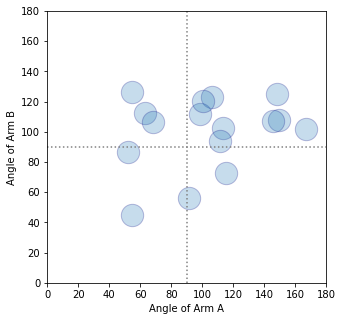

In [151]:
fig,ax=plt.subplots(figsize=[5,5])
ax.scatter(np.rad2deg(angles_A.T[0]), np.rad2deg(angles_B.T[0]),edgecolor='navy',alpha=0.25,s=500)
ax.set_ylim(0,180)
ax.set_xlim(0,180)
ax.axvline(90,ls=':',color='gray')
ax.axhline(90,ls=':',color='gray')
ax.set_xlabel('Angle of Arm A')
ax.set_ylabel('Angle of Arm B')

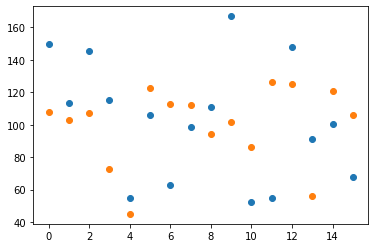

In [15]:
plt.scatter(list(range(0,len(angles_A))),np.rad2deg(angles_A))
plt.scatter(list(range(0,len(angles_B))),np.rad2deg(angles_B))